# ML Group Project - James Hardwick

Note that this notebook contains the final program.<br>
All experimentation is viewable on GitHub: https://github.com/jameshardweek/ML-Group-Project

Create dataframes from datasets

In [19]:
import pandas as pd

twitter_df = pd.read_table('https://raw.githubusercontent.com/ahmetaker/goodBadNews/master/good_badnews_Twitter.tsv')
news_df = pd.read_csv('https://raw.githubusercontent.com/ahmetaker/goodBadNews/master/good_badnews_NewsArticles.csv')

Script to get tweets from Twitter IDs is in file GetTweets.py<br>
Scraped dataset file is also included

Preprocessing function

In [20]:
import re

def process_text(text):
    # Remove all URLs from text
    text = re.sub(r'https?://\S+', '', text).strip()
    # Only include alphabetical characters
    text = ''.join([x.lower() for x in text if x.isalpha() or x == ' '])
    return ' '.join([x for x in text.split()])

Combine all text and labels into single dataframe

In [21]:
# Use scraped dataset
twitter_df = pd.read_csv('data/twitter_unprocessed.csv')
twitter_text = [x for x in twitter_df['text']]
twitter_labels = [x for x in twitter_df['status']]

news_text = [x for x in news_df['Title']]
news_labels = [x for x in news_df['Majority Score']]

Convert news dataset labels into 0 or 1

In [22]:
new_labels = []

for label in news_labels:
    if label == 2:
        new_labels.append(1)
    elif label == 3:
        new_labels.append(0)
    else:
        new_labels.append(label)

Combine datasets, with text preprocessing

In [23]:
all_text = twitter_text + news_text

clean_text = [process_text(x) for x in all_text]

y = twitter_labels + new_labels

from random import choices
choices(clean_text, k=5)

['hurricane irma remains a strong category storm as it moves closer to the caribbean',
 'pictures of police apprehending a suspect after the stockholm attack',
 'tracking hurricane irma',
 'gohsep monitoring remnants of harvey activating crisis action team lawx harvey',
 'serv servicemaster restore experts urge preparedness as harvey bears down on texas gulf coast']

Create TFIDF Vectorizer object and train with all text

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

td = TfidfVectorizer()
X = td.fit_transform(clean_text)

Create training and test data

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Create SVM classifier

In [26]:
from sklearn import svm

clf = svm.SVC().fit(X_train, y_train)
# clf = load('models/svm_both')

Make some predictions

In [27]:
y_pred = clf.predict(X_test)
y_pred[:10]

array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0])

View metrics on classifier

In [28]:
from sklearn.metrics import accuracy_score, classification_report

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print()
print(f'Classification Report:')
print(f'======================================================')
print(f'{classification_report(y_test, y_pred)}')
print(f'======================================================')

Accuracy: 0.9074935400516796

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1386
           1       0.86      0.81      0.83       549

    accuracy                           0.91      1935
   macro avg       0.89      0.88      0.88      1935
weighted avg       0.91      0.91      0.91      1935



Confusion Matrix

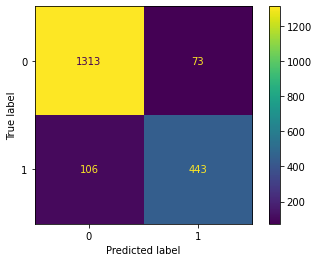

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Retrieve current country using IPInfo.io, to display only relevant headlines

In [30]:
import requests, json, iso3166

country = 'gb'

ip_info = requests.get('http://ipinfo.io/json').content
ip_info_json = json.loads(ip_info)
current_country = ip_info_json['country'].lower()

if current_country in iso3166.countries:
    country = current_country

country

'gb'

Get today's top headlines using NewsAPI

In [31]:
from datetime import date

API_KEY = "708ad74a333343d78c544425e5cb85cd"
DATE = date.today().strftime("%Y-%m-%d")

headlines = requests.get(f"https://newsapi.org/v2/top-headlines?country={country}&apiKey={API_KEY}").content
headlines_json = json.loads(headlines)

titles = [x['title'] for x in headlines_json['articles']]
choices(titles, k=5)

["F1 drivers have asked FIA to clean Miami's first corner - Motorsport.com",
 'Afghanistan face veil decree: ‘I’ve lost the right to choose my clothes’ - The Guardian',
 "Russia-Ukraine latest news: Liz Truss 'horrified' by school bombing that 'deliberately targeted' Ukrainian civilians - The Telegraph",
 'Cognitive Impairment From Severe COVID-19 Equivalent to 20 Years of Aging – Losing 10 IQ Points - SciTechDaily',
 "Beijing-backed hardliner John Lee chosen as Hong Kong's next leader - Financial Times"]

Retrain classifier using whole dataset for better accuracy

In [32]:
clf = svm.SVC().fit(X, y)

Make predictions on whether headline is good or bad and display only the predicted good headlines

In [33]:
good_headlines = []

for title in titles:
    title = ''.join(title.split(' - ')[:-1])
    clean_title = process_text(title)
    X = td.transform([clean_title])
    prediction = clf.predict(X)[0]

    if prediction == 1:
        good_headlines.append(title)

good_headlines

["F1 drivers have asked FIA to clean Miami's first corner",
 'From Barnard Castle to Beergate: Durham police chief at centre of national row again',
 'BAFTA TV Awards 2022: Celebrities take to the red carpet ahead of show',
 '‘Crypto muggings’: thieves in London target digital investors by taking phones',
 'Afghanistan face veil decree: ‘I’ve lost the right to choose my clothes’']